In [18]:
!pip install wordcloud


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# Load your dataset
df = pd.read_csv("C:/Perfume_success/final_perfume_data.csv", encoding='unicode_escape')  # Update with your actual path


In [2]:
# Set style for all plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
# ------------------------ BASIC INFO ------------------------

def basic_overview(data):
    print("\n[INFO] Dataset Overview:\n")
    print(data.info())
    print("\n[INFO] First 5 rows:\n", data.head())
    print("\n[INFO] Summary Statistics:\n", data.describe(include='all'))


In [4]:
# ------------------------ MISSING VALUES ------------------------

def visualize_missing(data):
    plt.figure(figsize=(8, 3))
    sns.heatmap(data.isnull(), cbar=False, cmap="coolwarm")
    plt.title("Missing Values Heatmap")
    plt.show()

In [5]:
# ------------------------ BRAND DISTRIBUTION ------------------------

def brand_distribution(data, top_n=10):
    top_brands = data['Brand'].value_counts().nlargest(top_n)
    sns.barplot(x=top_brands.index, y=top_brands.values, palette="mako")
    plt.title(f"Top {top_n} Brands")
    plt.xticks(rotation=45)
    plt.ylabel("Number of Perfumes")
    plt.tight_layout()
    plt.show()

In [6]:
# ------------------------ DESCRIPTION LENGTH ------------------------

def description_lengths(data):
    data['desc_length'] = data['Description'].astype(str).apply(lambda x: len(x.split()))
    sns.histplot(data['desc_length'], bins=30, kde=True, color="skyblue")
    plt.title("Description Length Distribution (in words)")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [7]:
# ------------------------ COMMON NOTES ------------------------

def common_notes(data, top_n=15):
    notes = data['Notes'].dropna().str.lower().str.replace(r"[^a-zA-Z, ]", "", regex=True).str.split(', ')
    all_notes = [note.strip() for sublist in notes for note in sublist if note.strip()]
    most_common = Counter(all_notes).most_common(top_n)

    labels, counts = zip(*most_common)
    sns.barplot(x=labels, y=counts, palette="viridis")  # Use the viridis palette without as_cmap=True
    plt.title(f"Top {top_n} Most Common Notes")
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()




In [8]:
# ------------------------ WORD CLOUD ------------------------

def wordcloud_descriptions(data):
    text = " ".join(data['Description'].dropna().astype(str))
    wc = WordCloud(background_color='white', max_words=200, colormap='viridis', width=800, height=400).generate(text)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Descriptions")
    plt.tight_layout()
    plt.show()


[INFO] Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         2191 non-null   object
 1   Brand        2191 non-null   object
 2   Description  2191 non-null   object
 3   Notes        2111 non-null   object
 4   Image URL    2191 non-null   object
dtypes: object(5)
memory usage: 85.7+ KB
None

[INFO] First 5 rows:
                                   Name          Brand  \
0                 Tihota Eau de Parfum         Indult   
1                          Sola Parfum         Di Ser   
2                       Kagiroi Parfum         Di Ser   
3         Velvet Fantasy Eau de Parfum        Montale   
4  A Blvd. Called Sunset Eau de Parfum  A Lab on Fire   

                                         Description  \
0   Rapa Nui for sugar, Tihota is, quite simply, ...   
1   A tribute to the expanse of space extending f...   


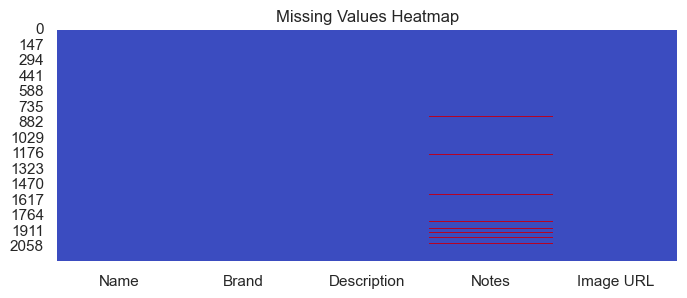

C:\Users\admin\AppData\Local\Temp\ipykernel_7288\2862138659.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.index, y=top_brands.values, palette="mako")


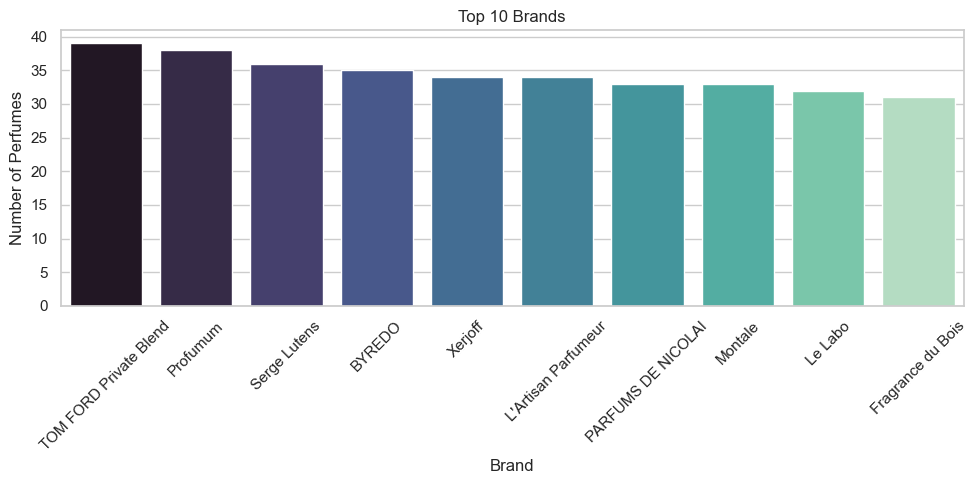

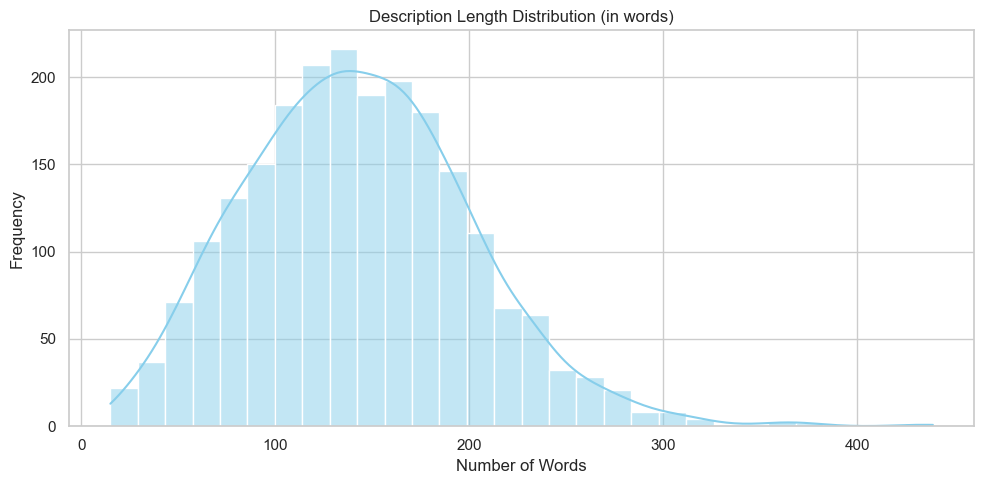

C:\Users\admin\AppData\Local\Temp\ipykernel_7288\4146255215.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="viridis")  # Use the viridis palette without as_cmap=True


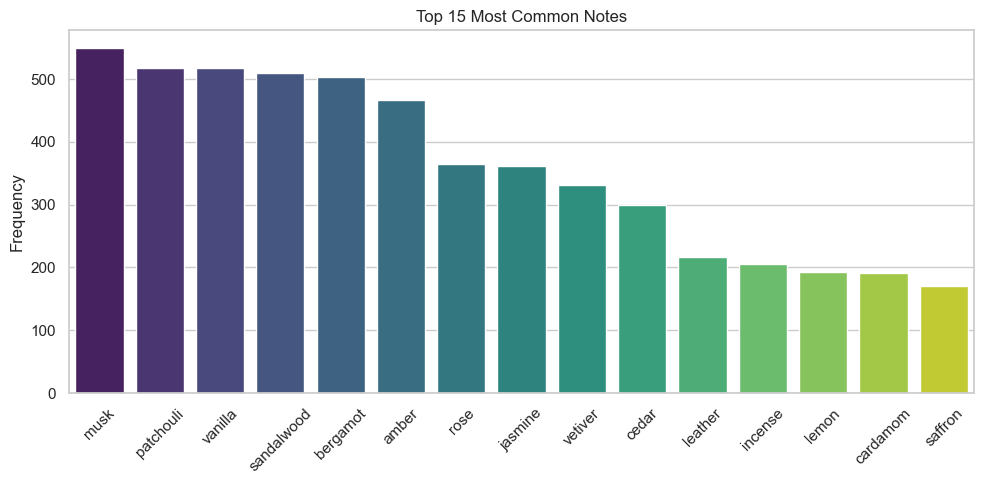

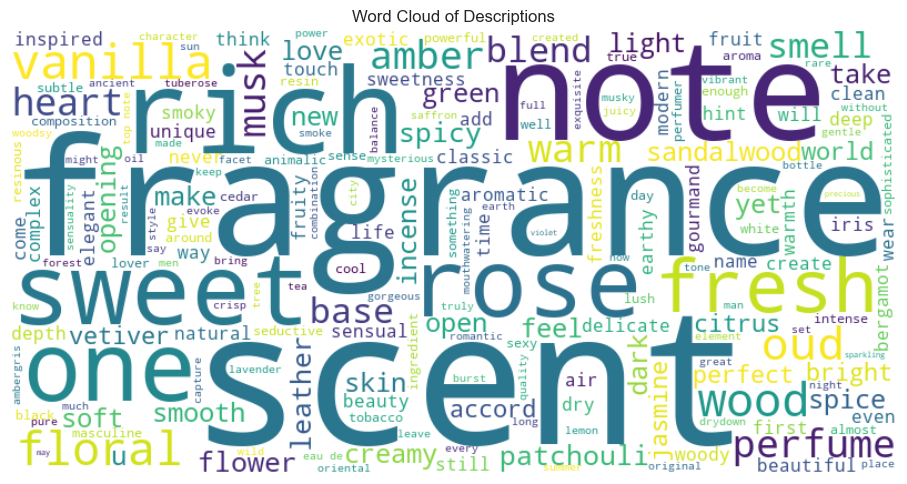

In [9]:
# ------------------------ RUN ALL ------------------------

def run_eda(data):
    basic_overview(data)
    visualize_missing(data)
    brand_distribution(data)
    description_lengths(data)
    common_notes(data)
    wordcloud_descriptions(data)

# Run EDA
run_eda(df)

In [10]:
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# --- 1. Load & Preprocess Data ---
df = pd.read_csv('C:/Perfume_success/final_perfume_data.csv', encoding='unicode_escape')
df = df.rename(columns={'Notes': 'Ingredients'})
df.fillna('', inplace=True)
df['Full Description'] = df['Description'].str.strip() + ' ' + df['Ingredients'].str.strip()


In [12]:
# Optional: Use a subset for quicker execution
df = df.sample(n=1000, random_state=42).reset_index(drop=True)

In [13]:
# --- 2. TF-IDF Vectorization (fewer features = faster) ---
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = vectorizer.fit_transform(df['Full Description'])

In [14]:
# --- 3. Precompute Cosine Similarity Matrix ---
cosine_sim_matrix = cosine_similarity(X_tfidf)

In [15]:
# --- 4. Create Positive & Negative Pairs ---
num_pos_pairs = 1000
all_indices = list(range(len(df)))
pos_pairs, neg_pairs = [], []

In [16]:
# Positive: similarity > 0.5
while len(pos_pairs) < num_pos_pairs:
    i, j = random.sample(all_indices, 2)
    if cosine_sim_matrix[i][j] > 0.5:
        pos_pairs.append((i, j))

In [17]:
# Negative: similarity < 0.2
while len(neg_pairs) < num_pos_pairs:
    i, j = random.sample(all_indices, 2)
    if cosine_sim_matrix[i][j] < 0.2:
        neg_pairs.append((i, j))

In [18]:
print(f"✅ Positive pairs: {len(pos_pairs)}, Negative pairs: {len(neg_pairs)}")

# --- 5. Feature Engineering ---
def pairwise_diff(i, j):
    return np.abs(X_tfidf[i] - X_tfidf[j]).toarray().ravel()

✅ Positive pairs: 1000, Negative pairs: 1000


In [19]:
pairs = pos_pairs + neg_pairs
labels = [1]*len(pos_pairs) + [0]*len(neg_pairs)

In [20]:
X = np.array([pairwise_diff(i, j) for i, j in pairs])
y = np.array(labels)


In [21]:
# --- 6. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [22]:
# --- 7. Train XGBoost Model ---
from xgboost import XGBClassifier
import joblib

model = XGBClassifier(
    eval_metric='logloss',      # Suitable for binary classification
    n_estimators=150,           # Keeps training efficient
    max_depth=5,                # Controls model complexity
    learning_rate=0.1,          # Balanced learning rate
    subsample=0.8,              # Prevents overfitting
    colsample_bytree=0.8,       # Random feature selection per tree
    random_state=42             # For reproducibility
)

model.fit(X_train, y_train)
# Save model
joblib.dump(model, 'xgboost_perfume_similarity_model.pkl')
print("✅ Model saved as 'xgboost_perfume_similarity_model.pkl'")


✅ Model saved as 'xgboost_perfume_similarity_model.pkl'


In [24]:
# --- 8. Evaluation ---
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n📈 XGBoost Similarity Accuracy: {acc:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Dissimilar', 'Similar']))


📈 XGBoost Similarity Accuracy: 0.9725

📊 Classification Report:
              precision    recall  f1-score   support

  Dissimilar       0.99      0.95      0.97       200
     Similar       0.96      0.99      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



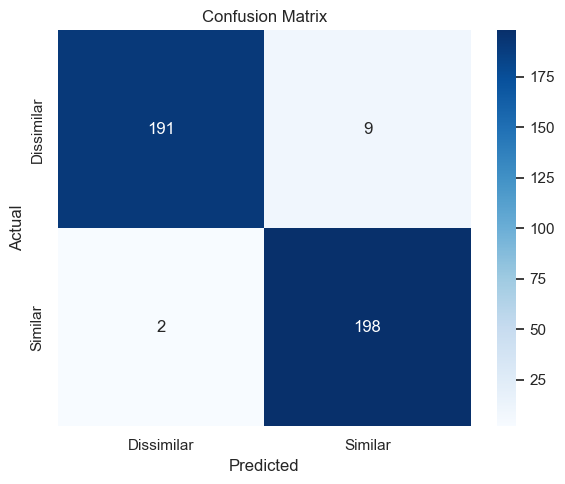

In [25]:
# --- 9. Confusion Matrix Visualization ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dissimilar', 'Similar'],
            yticklabels=['Dissimilar', 'Similar'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
